### 受限玻尔兹曼机（RBM）原理与代码实现总结
---
#### **一、RBM原理概述**
受限玻尔兹曼机（Restricted Boltzmann Machine）是一种基于能量的概率图模型，由可见层（Visible Layer）和隐层（Hidden Layer）组成，层内无连接，层间全连接。其核心是通过无监督学习学习数据的潜在特征分布。
##### **1. 模型结构**
- **可见层（v）**：输入数据的显式表示（如像素值）。
- **隐层（h）**：提取的潜在特征。
- **权重矩阵（W）**：连接可见层与隐层的权重。
- **偏置**：可见层偏置（b）和隐层偏置（c）。
##### **2. 能量函数与概率分布**
RBM的能量函数定义为：
$$
E(\mathbf{v}, \mathbf{h}) = -\mathbf{v}^T W \mathbf{h} - \mathbf{b}^T \mathbf{v} - \mathbf{c}^T \mathbf{h}
$$
联合概率分布通过玻尔兹曼分布给出：
$$
P(\mathbf{v}, \mathbf{h}) = \frac{ e^{-E(\mathbf{v}, \mathbf{h})} }{Z}
$$
其中 $ Z $ 为配分函数（归一化因子）。可见层的边缘分布为：
$$
P(\mathbf{v}) = \sum_{\mathbf{h}} P(\mathbf{v}, \mathbf{h})
$$
##### **3. 条件独立性**
由于层内无连接，给定可见层时隐层条件独立，反之亦然：
$$
P(h_j=1|\mathbf{v}) = \sigma\left(\sum_i W_{ij} v_i + c_j\right)
$$
$$
P(v_i=1|\mathbf{h}) = \sigma\left(\sum_j W_{ij} h_j + b_i\right)
$$
其中 $\sigma(x) = \frac{1}{1+e^{-x}}$ 为Sigmoid激活函数。
##### **4. 训练目标**
通过最大化似然函数学习参数（W, b, c）。目标函数为负对数似然：
$$
\mathcal{L} = -\sum_{\mathbf{v}} \log P(\mathbf{v})
$$
采用对比散度（CD）算法近似梯度，更新规则为：
$$
\Delta W_{ij} = \epsilon \left(\langle v_i h_j \rangle_{\text{data}} - \langle v_i h_j \rangle_{\text{recon}}\right)
$$
其中 $\epsilon$ 为学习率，$\langle \cdot \rangle_{\text{data}}$ 和 $\langle \cdot \rangle_{\text{recon}}$ 分别为数据分布和重构分布的期望。

---
#### **二、代码内容概括**
代码实现了RBM的训练与可视化，主要包含以下部分：
##### **1. 核心类 `RBMPretrainer`**
- **功能**：封装无监督堆叠RBM预训练、特征提取、及评估流程等。
- **关键参数**：
  - `hidden_layers_structure`：隐层单元数（默认[100]）
  - `learning_rate_rbm`：RBM学习率（默认0.1）
  - `n_epochs_rbm`：每层RBM训练轮数（默认10）
  - `batch_size`：批大小（默认100）
  - `verbose`：打印训练信息（默认True）
- **设备支持**：自动选择GPU（`cuda`）或CPU。
##### **2. 训练流程**
- **创建RBM层 (`_create_rbm_layer` 方法)**：使用 `RestrictedBoltzmannMachine` 定义可见层与隐层维度。
- **单批次训练步骤 (`_train_batch` 方法)**
    1. **正相（Positive Phase）**：计算隐层激活概率 $ P(\mathbf{h}|\mathbf{v}) $。
    2. **负相（Negative Phase）**：通过模拟退火采样器（`SimulatedAnnealingOptimizer`）生成重构样本。
    3. **目标函数**：最小化能量函数加权重衰减（L2正则化）。
    4. **反向传播**：更新权重和偏置。
- **单层RBM训练 (`_train_rbm_layer` 方法)**
    - **初始化优化器**：采用随机梯度下降（SGD）优化参数。
    - **DataLoader处理批量数据**
- **预训练堆叠RBM (`fit` 方法)**
- **特征变换，逐层提取特征 (`transform` 方法)**
##### **3. 其他内容**

- **数据加载 (`load_data` 方法)**

    - 数据集：使用 `sklearn.datasets.load_digits`（8x8手写数字图像）。
    - 增强：对原始图像进行上下左右平移，扩展数据集。

- **训练过程可视化 (`_visualize_training_progress` 方法, 设置`plot_img=True`)**

    - 权重与梯度：实时监控权重矩阵及其梯度变化。
    - 生成样本：实时展示模型"生成"新样本的能力
    - 重建样本：可视化重建误差的演变

- **结果可视化 (`RBMVisualizer`类)**

    - 训练后RBM权重可视化
    - 分类任务结果: 混淆矩阵可视化
    - 重建样本：训练完成后对测试图像进行编码-解码得到的重建

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import time

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

seed = 42
# PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)       # 为当前GPU设置
    torch.cuda.manual_seed_all(seed)   # 为所有GPU设置
# Python
random.seed(seed)
# NumPy
np.random.seed(seed)


[DBN] Pre-training RBM layer 1/1: 64 -> 128
[DBN] Pre-training start:
jmean 0.039224jmax 0.124513
hmean 0.050444hmax 0.100000
Iteration 1, Average Loss: 0.047286
Iteration 6, Average Loss: 1.319106
Iteration 11, Average Loss: 1.728505
Iteration 16, Average Loss: 0.717645
jmean 0.047255jmax 0.205040
hmean 0.551140hmax 0.824064
Iteration 21, Average Loss: 1.234921
Iteration 26, Average Loss: 2.500786
Iteration 31, Average Loss: 2.972221
Iteration 36, Average Loss: 2.703542
jmean 0.044843jmax 0.235873
hmean 0.753888hmax 0.990000
Iteration 41, Average Loss: 2.165888
Iteration 46, Average Loss: 2.341195
Iteration 51, Average Loss: 2.637608
Iteration 56, Average Loss: 2.958680
jmean 0.054843jmax 0.215358
hmean 0.765073hmax 1.014363
Iteration 61, Average Loss: 2.750337
Iteration 66, Average Loss: 1.918549
Iteration 71, Average Loss: 1.784142
Iteration 76, Average Loss: 1.945763
jmean 0.065556jmax 0.349857
hmean 0.859297hmax 1.068941
Iteration 81, Average Loss: 1.389374
Iteration 86, Average 

,hidden_layers_structure,[128]
,learning_rate_rbm,0.1
,n_epochs_rbm,2
,batch_size,64
,verbose,True
,shuffle,True
,drop_last,False
,plot_img,False
,random_state,42


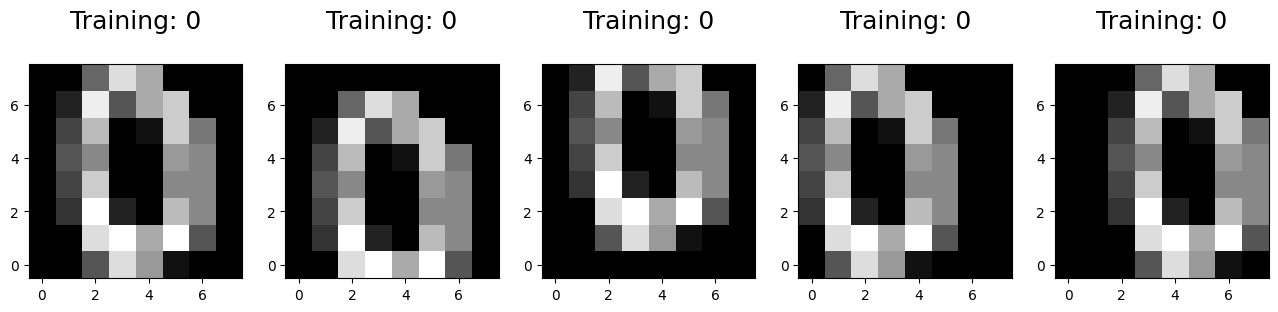

In [2]:
from rbm_digits import load_data, RBMVisualizer, RBMPretrainer
import kaiwu as kw
# 添加license相关信息
# kw.license.init(user_id="", sdk_code="")

logistic = LogisticRegression(random_state=seed)

# 初始化RBM
model = RBMPretrainer(
    hidden_layers_structure=[128],
    learning_rate_rbm=0.1,
    n_epochs_rbm=2,
    batch_size=64,
    verbose=True,
    plot_img=False,
    random_state=seed
)

# 加载数据
X_train, X_test, y_train, y_test = load_data(plot_img=True)

#训练
model.fit(X_train)

In [3]:
# 特征提取
rbm_train = model.transform(X_train)
rbm_test = model.transform(X_test)

# 下游classifier
logistic_classifier = LogisticRegression(C=500.0, max_iter=1000, random_state=seed)

start_time = time.time()
# logistic_classifier.fit(X_train, y_train)
logistic_classifier.fit(rbm_train, y_train)
training_time = time.time() - start_time
print(f"Logistic regression training completed in {training_time:.2f} seconds")

########## 评估模型 ##########
rbm_pred = logistic_classifier.predict(rbm_test)
rbm_acc = accuracy_score(y_test, rbm_pred)
print("\nLogistic regression using DBN features:\n%s\n" % (
    classification_report(
        y_test,
        rbm_pred)))
print(f"Test Accuracy: {rbm_acc:.4f}")

Logistic regression training completed in 1.46 seconds

Logistic regression using DBN features:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       188
           1       0.79      0.79      0.79       183
           2       0.83      0.83      0.83       172
           3       0.87      0.82      0.84       205
           4       0.87      0.86      0.87       168
           5       0.82      0.81      0.82       183
           6       0.95      0.93      0.94       183
           7       0.89      0.94      0.91       189
           8       0.80      0.77      0.78       160
           9       0.76      0.79      0.77       166

    accuracy                           0.85      1797
   macro avg       0.85      0.85      0.85      1797
weighted avg       0.85      0.85      0.85      1797


Test Accuracy: 0.8536


/Users/chang137/GitHub/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


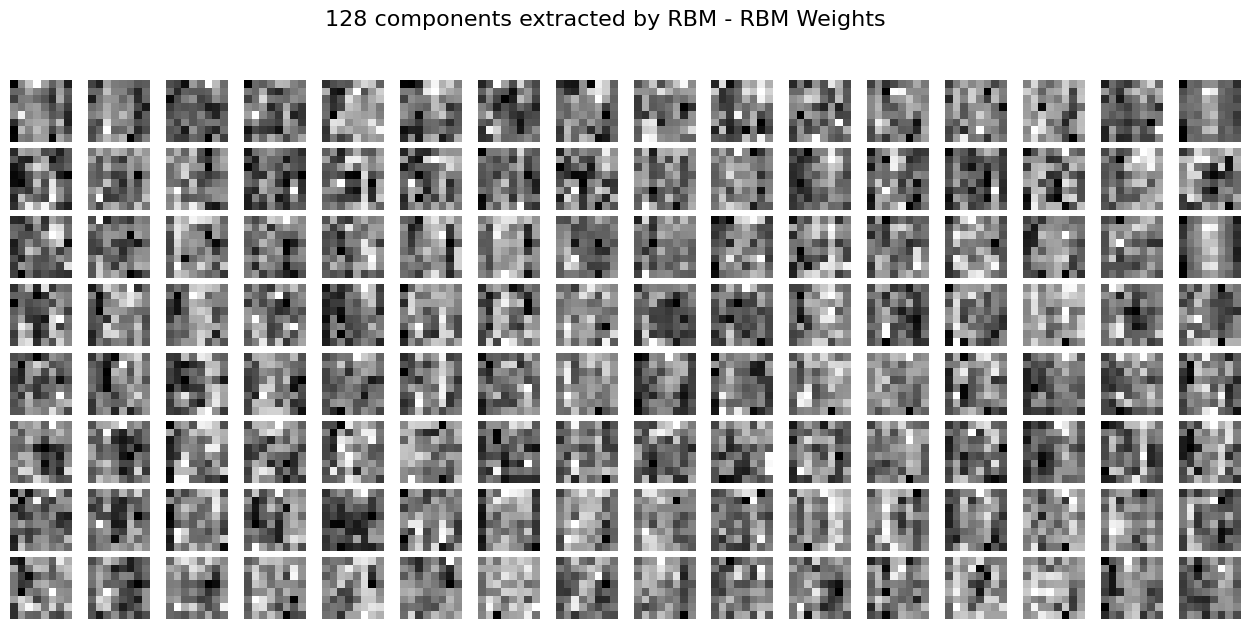

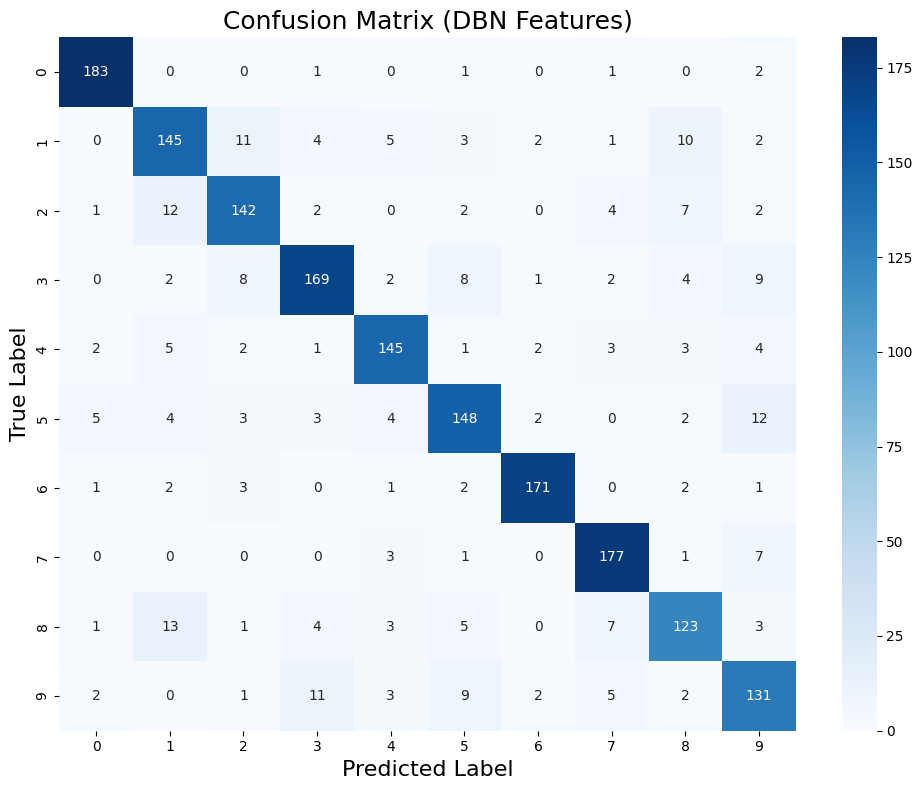

In [4]:
# 初始化可视化
visualizer = RBMVisualizer(result_dir='results')

# 绘制权重
visualizer.plot_weights(model._dbn.rbm_layers[0], save_pdf=False)

# 绘制混淆矩阵
visualizer.plot_confusion_matrix(y_test, rbm_pred, title_suffix="DBN Features", save_pdf=False)


Reconstructing 10 test images...


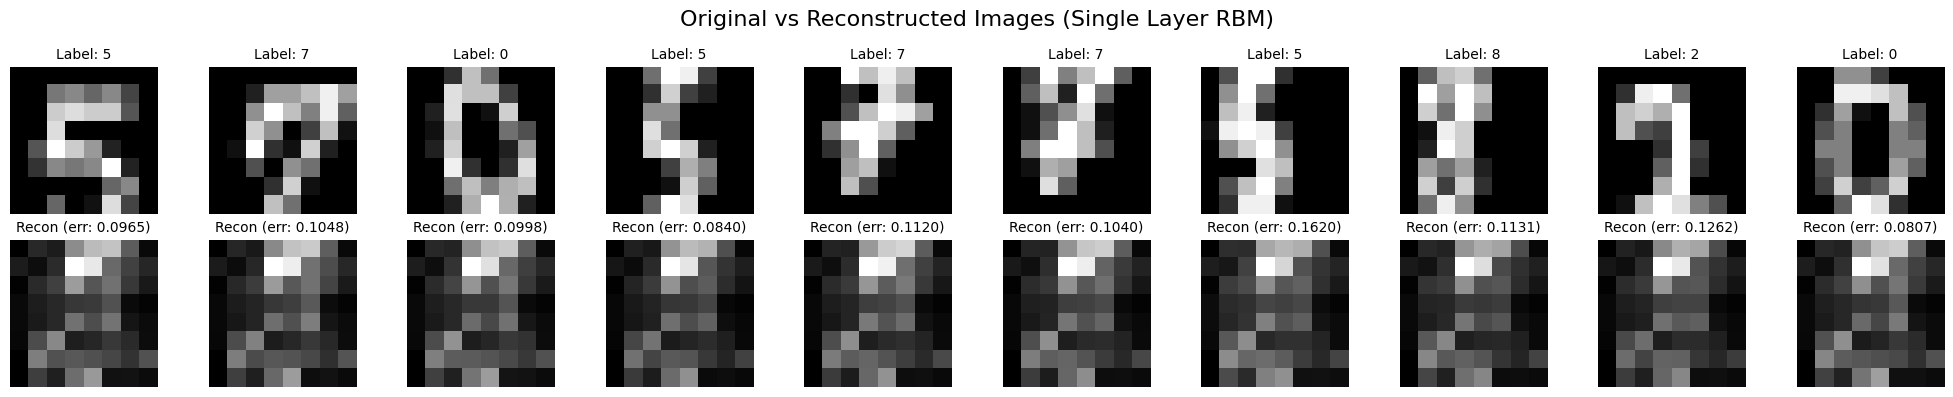

Average reconstruction error: 0.1083


In [5]:
# 选择一些测试图像进行重建
n_samples = 10
test_indices = np.random.choice(len(X_test), n_samples, replace=False)
X_sample = X_test[test_indices]
y_sample = y_test[test_indices]

print(f"\nReconstructing {n_samples} test images...")

# 绘制原始vs重建图像
recon_errors = visualizer.plot_reconstructed_images(
    model._dbn,
    X_sample, y_sample, 
    layer_index=0,
    n_images=n_samples,
    title_suffix="Single Layer RBM",
    save_pdf=True,
    img_shape=(8, 8)  # 对于8x8的数字图像
)